In [1]:
import torch
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from make_dataset import DataGen
import matplotlib.pyplot as plt
import os
import pandas as pd
import torchvision
import torch.nn as nn
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler
import cv2
import time

c:\Users\collaborations\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## TODO: get list of image paths and labels
img_labels = pd.read_csv('data/per_scan_data.csv')

In [3]:
img_labels.head()

,scan_name,scan_number,folder_name,patient_id,eye_side,status
0,064_OS_6_GA_6x6_SSOCT_1_168.jpg,168,064_OS_6_GA_6x6_SSOCT_1,64,left,False
1,064_OS_6_GA_6x6_SSOCT_1_202.jpg,202,064_OS_6_GA_6x6_SSOCT_1,64,left,True
2,064_OS_6_GA_6x6_SSOCT_1_397.jpg,397,064_OS_6_GA_6x6_SSOCT_1,64,left,False
3,064_OS_6_GA_6x6_SSOCT_1_204.jpg,204,064_OS_6_GA_6x6_SSOCT_1,64,left,True
4,064_OS_6_GA_6x6_SSOCT_1_44.jpg,44,064_OS_6_GA_6x6_SSOCT_1,64,left,False


In [4]:
# Open the file with all images
all_slices_path = r'\\fsmresfiles.fsm.northwestern.edu\fsmresfiles\Ophthalmology\Mirza_Images\AMD\dAMD_GA\all_slices_3'
all_slices = os.listdir(all_slices_path)

# collect all images 
all_imgs = [item for item in all_slices if item.endswith('.jpg')]
print(len(all_imgs))

21500


In [5]:
def find_labels(image_list):
    labels = []
    name_column = 'scan_name'
    for image_name in image_list:
        found_row = img_labels[img_labels[name_column] == image_name]
        if found_row['status'].item() == True:
            labels.append(1)
        else: 
            labels.append(0)
    return labels


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model.parameters():
    param.requires_grad = False
    
nr_filters = model.fc.in_features
model.fc = nn.Linear(nr_filters, 1)
model = model.to(device)
for name, parameter in model.named_parameters():
    if 'fc' in name:
        print(f"parameter '{name}' will not be freezed")
        parameter.requires_grad = True
    else:
        parameter.requires_grad = False

print(model)

parameter 'fc.weight' will not be freezed
parameter 'fc.bias' will not be freezed
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, moment

In [7]:
train_image_names, val_image_names, test_image_names = torch.utils.data.random_split(all_imgs, [15000,3250,3250])
train_set_labels = find_labels(train_image_names)
val_set_labels = find_labels(val_image_names)
test_set_labels = find_labels(test_image_names)

In [8]:
train_tensors = []
val_tensors = []
test_tensors = []

In [9]:
train_data = []
for i in range(len(train_image_names)):
    temp_img = torchvision.io.read_image(all_slices_path+"/"+train_image_names[i])
    temp_img = temp_img.repeat(3,1,1)
    train_data.append([temp_img, train_set_labels[i]])
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=32)

val_data = []
for i in range(len(val_image_names)):
    temp_img = torchvision.io.read_image(all_slices_path+"/"+val_image_names[i])
    temp_img = temp_img.repeat(3,1,1)
    val_data.append([temp_img, val_set_labels[i]])
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=32)

test_data = []
for i in range(len(test_image_names)):
    temp_img = torchvision.io.read_image(all_slices_path+"/"+test_image_names[i])
    temp_img = temp_img.repeat(3,1,1)
    test_data.append([temp_img, test_set_labels[i]])
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=32)

torch.Size([3, 1536, 500])


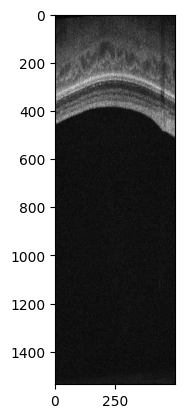

In [10]:
#img = cv2.imread(all_slices_path+"/"+train_image_names[0])
# test = torchvision.io.read_image(all_slices_path+"/"+train_image_names[1])
# test = test.repeat(3,1,1)
plt.imshow(test_data[0][0].permute(1,2,0))
print(test_data[0][0].size())
plt.show()

In [11]:
print(len(val_loader))
print(len(train_loader))

102
469


In [12]:
criterion = BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## start training
num_epochs = 20
train_losses_batch = []
val_losses_batch = []

train_losses_epoch = []
val_losses_epoch = []

train_acc_batch = []
val_acc_batch = []

train_acc_epoch = []
val_acc_epoch = []

overall_loss_epoch = []
overall_acc_epoch = []

since = time.time()

print("starting training: ")
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)
    phase_loader = None 

    temp_train_loss = 0.0
    temp_val_loss = 0.0
    temp_train_acc = 0.0
    temp_val_acc = 0.0

    for phase in ['train', 'val']:
        print("running phase ", phase)
        if phase == 'train':
            model.train()  # Set model to training mode
            phase_loader = train_loader
        else:
            model.eval()   # Set model to evaluate mode
            phase_loader = val_loader
                
        running_loss = 0.0
        running_corrects = 0
    
        #iterate over the data
        for inputs, labels in phase_loader:
            inputs = inputs.float().to(device)
            labels = labels.float().to(device)
    
            # zero the parameter gradients 
            optimizer.zero_grad()
    
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase=='train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                outputs = outputs.squeeze()
                loss = criterion(outputs, labels)
                    
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
        
            # statistics 
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    
            if phase == 'train':
                # train_losses.append(running_loss / len(labels))
                train_losses_batch.append(loss.item())
                train_acc_batch.append(100 * running_corrects / len(labels))

                temp_train_loss += loss.item()
                temp_train_acc = torch.sum(preds == labels.data)

                scheduler.step()
            else:
                # val_losses.append(running_loss / len(labels))
                val_losses_batch.append(loss.item())
                val_acc_batch.append(100 * running_corrects / len(labels))

                temp_val_loss += loss.item()
                temp_val_acc = torch.sum(preds == labels.data)
                                        
    
        epoch_all_loss = running_loss / len(train_loader)
        overall_loss_epoch.append(epoch_all_loss)
        epoch_all_acc = running_corrects.double() / len(train_loader)
        overall_acc_epoch.append(epoch_all_acc)

        
        print(f' {phase} Loss: {epoch_all_loss:.4f} Acc: {epoch_all_acc:.4f}')

        if phase == 'val' and epoch_all_acc > best_acc:
            best_acc = epoch_all_acc
            torch.save(model.state_dict(), 'model_epoch'+str(epoch)+'.pt')

time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best val Acc: {best_acc:4f}')


starting training: 
Epoch 0/19
----------
running phase  train
 train Loss: 19.7090 Acc: 22.2473
running phase  val
 val Loss: 4.2604 Acc: 4.8316
Epoch 1/19
----------
running phase  train
 train Loss: 19.7066 Acc: 22.2473
running phase  val
 val Loss: 4.2596 Acc: 4.8316
Epoch 2/19
----------
running phase  train
 train Loss: 19.7089 Acc: 22.2473
running phase  val
 val Loss: 4.2596 Acc: 4.8316
Epoch 3/19
----------
running phase  train
 train Loss: 19.7090 Acc: 22.2473
running phase  val
 val Loss: 4.2608 Acc: 4.8316
Epoch 4/19
----------
running phase  train
 train Loss: 19.7092 Acc: 22.2473
running phase  val
 val Loss: 4.2595 Acc: 4.8316
Epoch 5/19
----------
running phase  train
 train Loss: 19.7077 Acc: 22.2473
running phase  val
 val Loss: 4.2602 Acc: 4.8316
Epoch 6/19
----------
running phase  train
 train Loss: 19.7136 Acc: 22.2473
running phase  val
 val Loss: 4.2583 Acc: 4.8316
Epoch 7/19
----------
running phase  train
 train Loss: 19.7120 Acc: 22.2473
running phase  val
 v

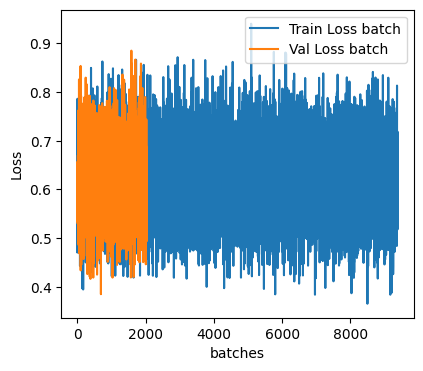

In [13]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses_batch, label='Train Loss batch')
plt.plot(val_losses_batch, label='Val Loss batch')
plt.xlabel('batches')
plt.ylabel('Loss')
plt.legend()

plt.savefig("val_train_losses_batch.png")

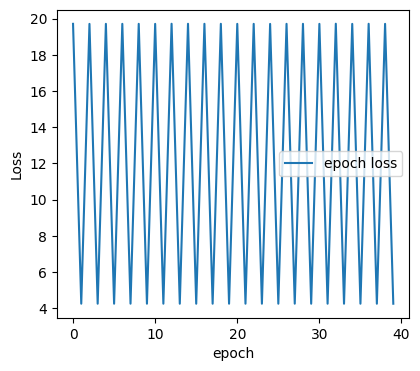

In [21]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(overall_loss_epoch, label='epoch loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig("val_train_losses_epochs.png")

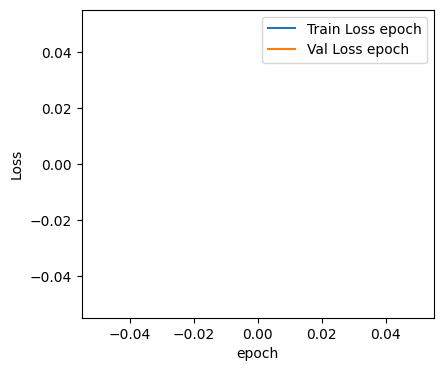

In [22]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses_epoch, label='Train Loss epoch')
plt.plot(val_losses_epoch, label='Val Loss epoch')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig("val_train_losses_epochs.png")

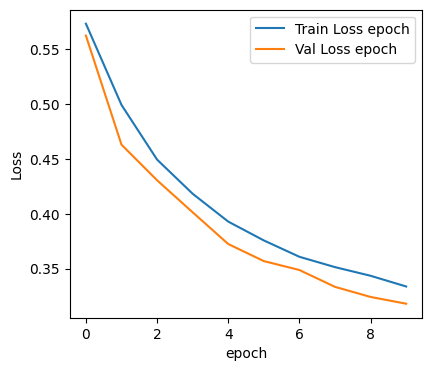

In [2]:
laura_train_loss=[0.5731560314810553, 0.49916648837023003, 0.4493455610996069, 0.41824471714884737, 0.3928610172036082, 0.37569986782794773, 0.36080164171235507, 0.35138813278009723, 0.34350442903679473, 0.33374098927475687  ]
laura_valid_loss = [0.5623090151283476, 0.4629473716572479, 0.43052715587395207, 0.4013273310330179, 0.3724303091013873, 0.35688059666642435, 0.3487548353495421, 0.33340207528736854, 0.3242166892245964, 0.3180446456427927 ]
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(laura_train_loss, label='Train Loss epoch')
plt.plot(laura_valid_loss, label='Val Loss epoch')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig("val_train_losses_epochs.png")
